# Import required libraries

In [161]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from experiments.CarOnHill.plot_utils import plot_on_grid, plot_value
from slimRL.sample_collection.utils import load_replay_buffer_store
from experiments.CarOnHill.optimal import NX, NV

BASE_PATH = "logs/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyperparameter setting for generating the plots

In [162]:
# Set these value before running the cells below
experiments_to_run = ["test2/FQI"]
# Set these value to True if you want to generate these plots
SAMPLES_DISTRIBUTION = True
PERFORMANCE_LOSS = False
APPROX_ERROR_ON_RB_DATA = True
BELLMAN_ITERATIONS_FOR_POLICY = [5, 10, 15, 20, 25, 29]
BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS = []
OVERESTIMATION_ERROR = False

# Check and load all the relevant metrics for plotting

In [163]:
if PERFORMANCE_LOSS:
    OPT_Q = np.load(os.path.join(BASE_PATH, "Q*.npy"))
if len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS) > 0:
    OPT_V = np.load(os.path.join(BASE_PATH, "V*.npy"))
experiment_seed_folder_map = {
    experiment: [
        seed_run
        for seed_run in os.listdir(os.path.join(BASE_PATH, experiment))
        if not os.path.isfile(os.path.join(BASE_PATH, experiment, seed_run))
    ]
    for experiment in experiments_to_run
}
assert all(
    [
        os.path.exists(os.path.join(BASE_PATH, experiment_folder_path))
        for experiment_folder_path in experiment_seed_folder_map
    ]
), "Found experiments with no corresponing folders"
metrics = {}
for experiment in experiment_seed_folder_map:
    metrics[experiment] = {}
    if SAMPLES_DISTRIBUTION:
        metrics[experiment].setdefault(
            "samples_distribution",
            np.load(os.path.join(BASE_PATH, experiment, "samples_stats.npy")),
        )
        metrics[experiment].setdefault(
            "rewards_distribution",
            np.load(os.path.join(BASE_PATH, experiment, "rewards_stats.npy")),
        )
    if (
        PERFORMANCE_LOSS
        or len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS) > 0
        or OVERESTIMATION_ERROR
    ):
        metrics[experiment].setdefault(
            "samples_distribution",
            np.load(os.path.join(BASE_PATH, experiment, "samples_stats.npy")),
        )
        metrics[experiment].setdefault(
            "scaling",
            metrics[experiment]["samples_distribution"]
            / metrics[experiment]["samples_distribution"].sum(),
        )
    if PERFORMANCE_LOSS:
        metrics[experiment].setdefault(
            "q_pi",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "q_pi.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )
    if APPROX_ERROR_ON_RB_DATA:
        metrics[experiment].setdefault(
            "Tq_rb",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "Tq_rb.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )
        metrics[experiment].setdefault(
            "q_rb",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "q_rb.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )
        metrics[experiment].setdefault(
            "rb_store",
            load_replay_buffer_store(
                os.path.join(BASE_PATH, experiment, "replay_buffer.json")
            ),
        )
    if len(BELLMAN_ITERATIONS_FOR_POLICY) > 0:
        metrics[experiment].setdefault(
            f"q_grid",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "q_grid.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )
    if len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS) > 0 or OVERESTIMATION_ERROR:
        metrics[experiment].setdefault(
            "q_pi",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "q_pi.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )
        metrics[experiment].setdefault(
            "q_grid",
            {
                seed_run: np.load(
                    os.path.join(BASE_PATH, experiment, seed_run, "q_grid.npy")
                )
                for seed_run in experiment_seed_folder_map[experiment]
            },
        )

## Plot samples distribution 

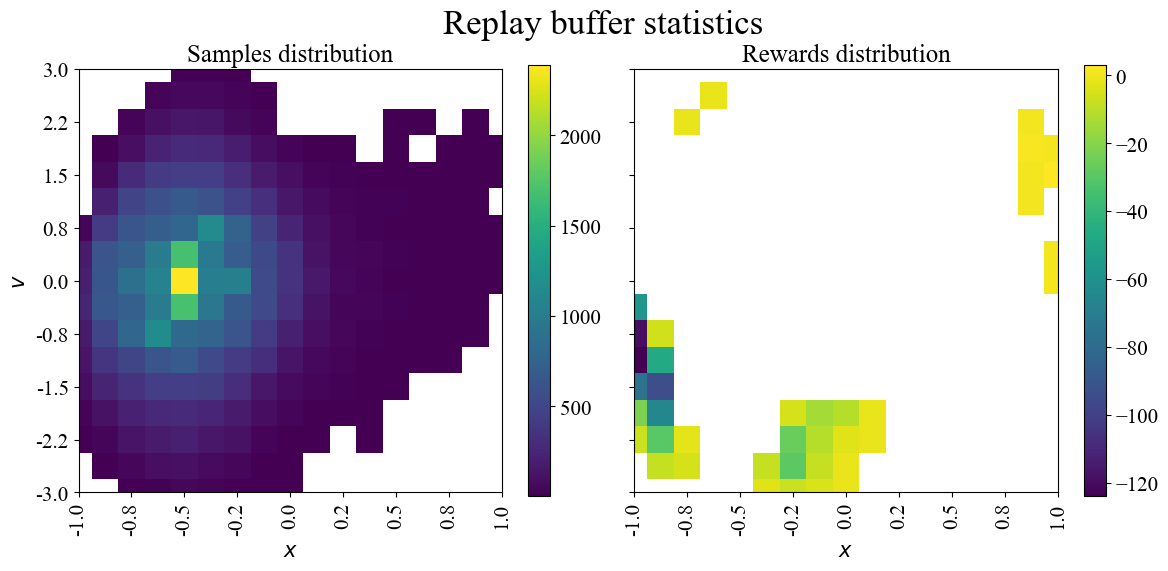

In [164]:
if SAMPLES_DISTRIBUTION:
    TITLES = {
        "samples_distribution": "Samples distribution",
        "rewards_distribution": "Rewards distribution",
    }
    for experiment in experiment_seed_folder_map:
        plot_on_grid(
            values={
                TITLES[p]: metrics[experiment][p]
                for p in ["samples_distribution", "rewards_distribution"]
            },
            shared_cmap=False,
            zeros_to_nan=True,
            title="Replay buffer statistics",
            fontsize=15,
            title_fontsize=20,
        ).savefig(
            os.path.join(BASE_PATH, experiment, "samples_distribution.pdf"),
            bbox_inches="tight",
        )

## Plot $\Vert Q^{*} - Q^{\pi_i}\Vert_{1, \mu_{D}}$

In [165]:
if PERFORMANCE_LOSS:
    q_perf_loss = {}
    for experiment in experiment_seed_folder_map:
        n_seeds = len(metrics[experiment]["q_pi"])
        n_bellman_iterations = list(metrics[experiment]["q_pi"].values())[0].shape[0]
        q_perf_loss[experiment] = np.zeros((n_seeds, n_bellman_iterations))
        for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
            q_perf_loss[experiment][idx_seed] = np.sqrt(
                np.sum(
                    np.abs(OPT_Q.reshape(-1, 2) - metrics[experiment]["q_pi"][seed_run])
                    * metrics[experiment]["scaling"].reshape(-1)[:, np.newaxis],
                    axis=(1, 2),
                )
            )
    plot_value(
        "Bellman iteration",
        "$\Vert Q^{*} - Q^{\pi_i}\Vert_{1, \mu_{D}}$",
        np.arange(0, n_bellman_iterations).tolist(),
        q_perf_loss,
        ticksize=10,
        title="Performance loss",
        fontsize=20,
        linewidth=3,
        xlim=(0, n_bellman_iterations),
        xticks=[0]
        + [
            idx * 10 ** (int(np.log10(n_bellman_iterations)))
            for idx in range(
                1,
                int(
                    np.ceil(
                        n_bellman_iterations
                        / 10 ** (int(np.log10(n_bellman_iterations)))
                    )
                )
                + 1,
            )
        ],
    ).savefig(
        os.path.join(BASE_PATH, experiments_to_run[0], "performance_loss_q.pdf"),
        bbox_inches="tight",
    )

## Plot $\Vert \Gamma Q_{i-1} - Q_i\Vert^2_{2, \mu_{D}}$ on replay buffer data

In [179]:
metrics[experiment]["q_rb"][seed_run].shape

(31, 49986, 2)

ValueError: x and y must have same first dimension, but have shapes (31,) and (30,)

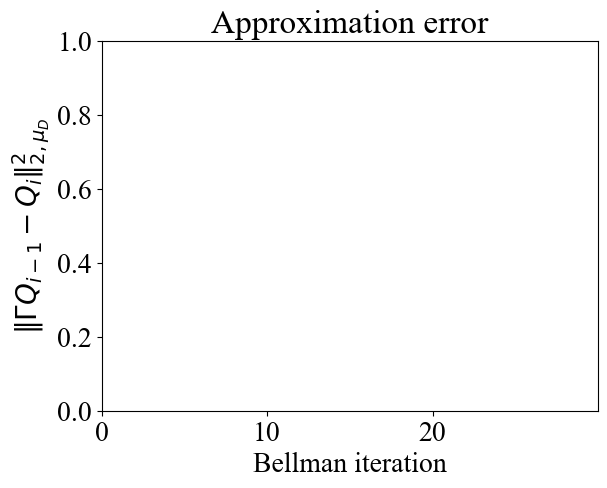

In [182]:
if APPROX_ERROR_ON_RB_DATA:
    approx_error_on_rb = {}
    for experiment in experiment_seed_folder_map:
        n_seeds = len(metrics[experiment]["q_rb"])
        n_bellman_iterations = list(metrics[experiment]["q_rb"].values())[0].shape[0]
        approx_error_on_rb[experiment] = np.zeros((n_seeds, n_bellman_iterations - 1))
        for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
            approx_error_on_rb[experiment][idx_seed] = (
                np.linalg.norm(
                    metrics[experiment]["Tq_rb"][seed_run][:-1]
                    - metrics[experiment]["q_rb"][seed_run][1:][
                        np.arange(n_bellman_iterations - 1)[:, None],
                        np.arange(len(metrics[experiment]["rb_store"]["actions"])),
                        metrics[experiment]["rb_store"]["actions"],
                    ],
                    axis=1,
                )
                ** 2
            )
    plot_value(
        "Bellman iteration",
        "$\Vert \Gamma Q_{i-1} - Q_i\Vert^2_{2, \mu_{D}}$",
        np.arange(1, n_bellman_iterations).tolist(),
        approx_error_on_rb,
        ticksize=10,
        title="Approximation error",
        fontsize=20,
        linewidth=3,
        xlim=(0, n_bellman_iterations - 1),
        xticks=[0]
        + [
            idx * 10 ** (int(np.log10(n_bellman_iterations)))
            for idx in range(
                1,
                (n_bellman_iterations // (10 ** (int(np.log10(n_bellman_iterations)))))
                + 1,
            )
        ],
    ).savefig(
        os.path.join(BASE_PATH, experiments_to_run[0], "approx_error_rb_data.pdf"),
        bbox_inches="tight",
    )

## Plot policy $\pi_i(s)$

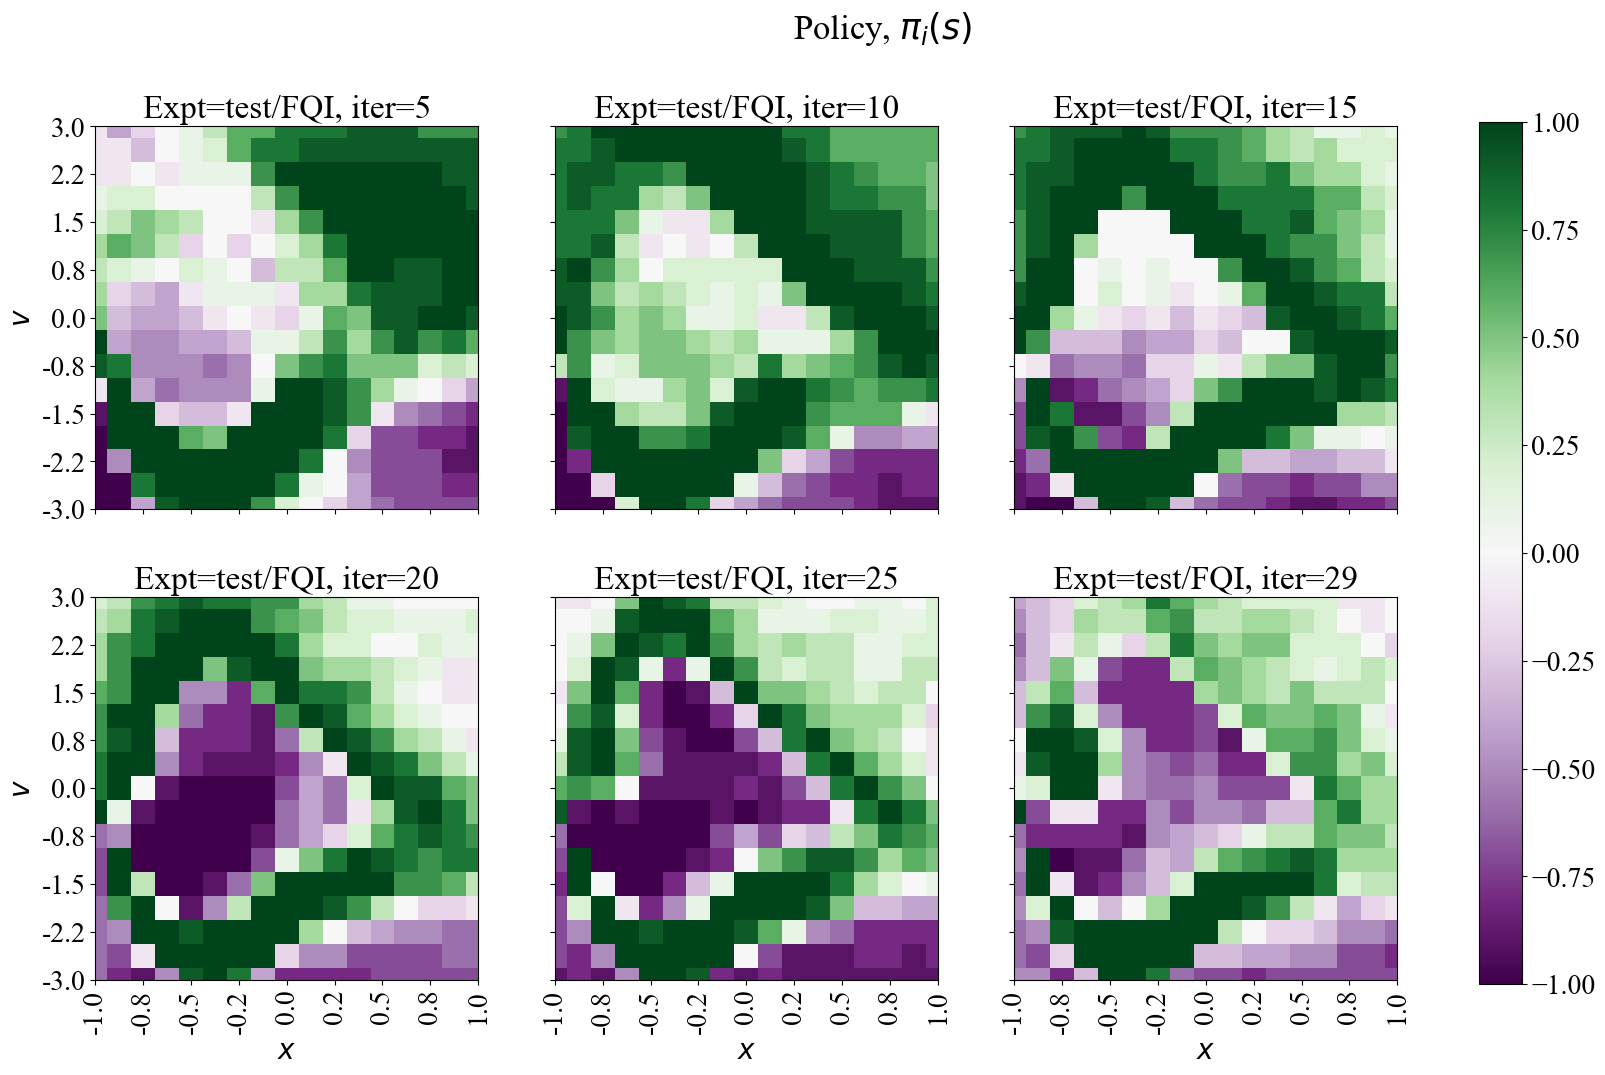

In [157]:
if len(BELLMAN_ITERATIONS_FOR_POLICY) > 0:
    policies = {}
    for iteration in BELLMAN_ITERATIONS_FOR_POLICY:
        for experiment in experiment_seed_folder_map:
            n_seeds = len(metrics[experiment]["q_grid"])
            policy = np.zeros((n_seeds, NX * NV))
            for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
                policy[idx_seed] = (
                    metrics[experiment]["q_grid"][seed_run][iteration][:, 1]
                    > metrics[experiment]["q_grid"][seed_run][iteration][:, 0]
                ).astype(float)
            policy = np.mean(policy, axis=0)
            policy = (
                2 * (policy - np.min(policy)) / (np.max(policy) - np.min(policy)) - 1
            )
            policy = policy.reshape(NX, NV)
            policies[f"Expt={experiment}, iter={iteration}"] = policy
    plot_on_grid(
        policies,
        shared_cmap=True,
        cmap="PRGn",
        title="Policy, $\pi_i(s)$",
        fontsize=20,
        title_fontsize=30,
    ).savefig(os.path.join(BASE_PATH, experiment, f"policy.pdf"), bbox_inches="tight")

## Plot $V^{*} - V^{\pi_i}$ on grid

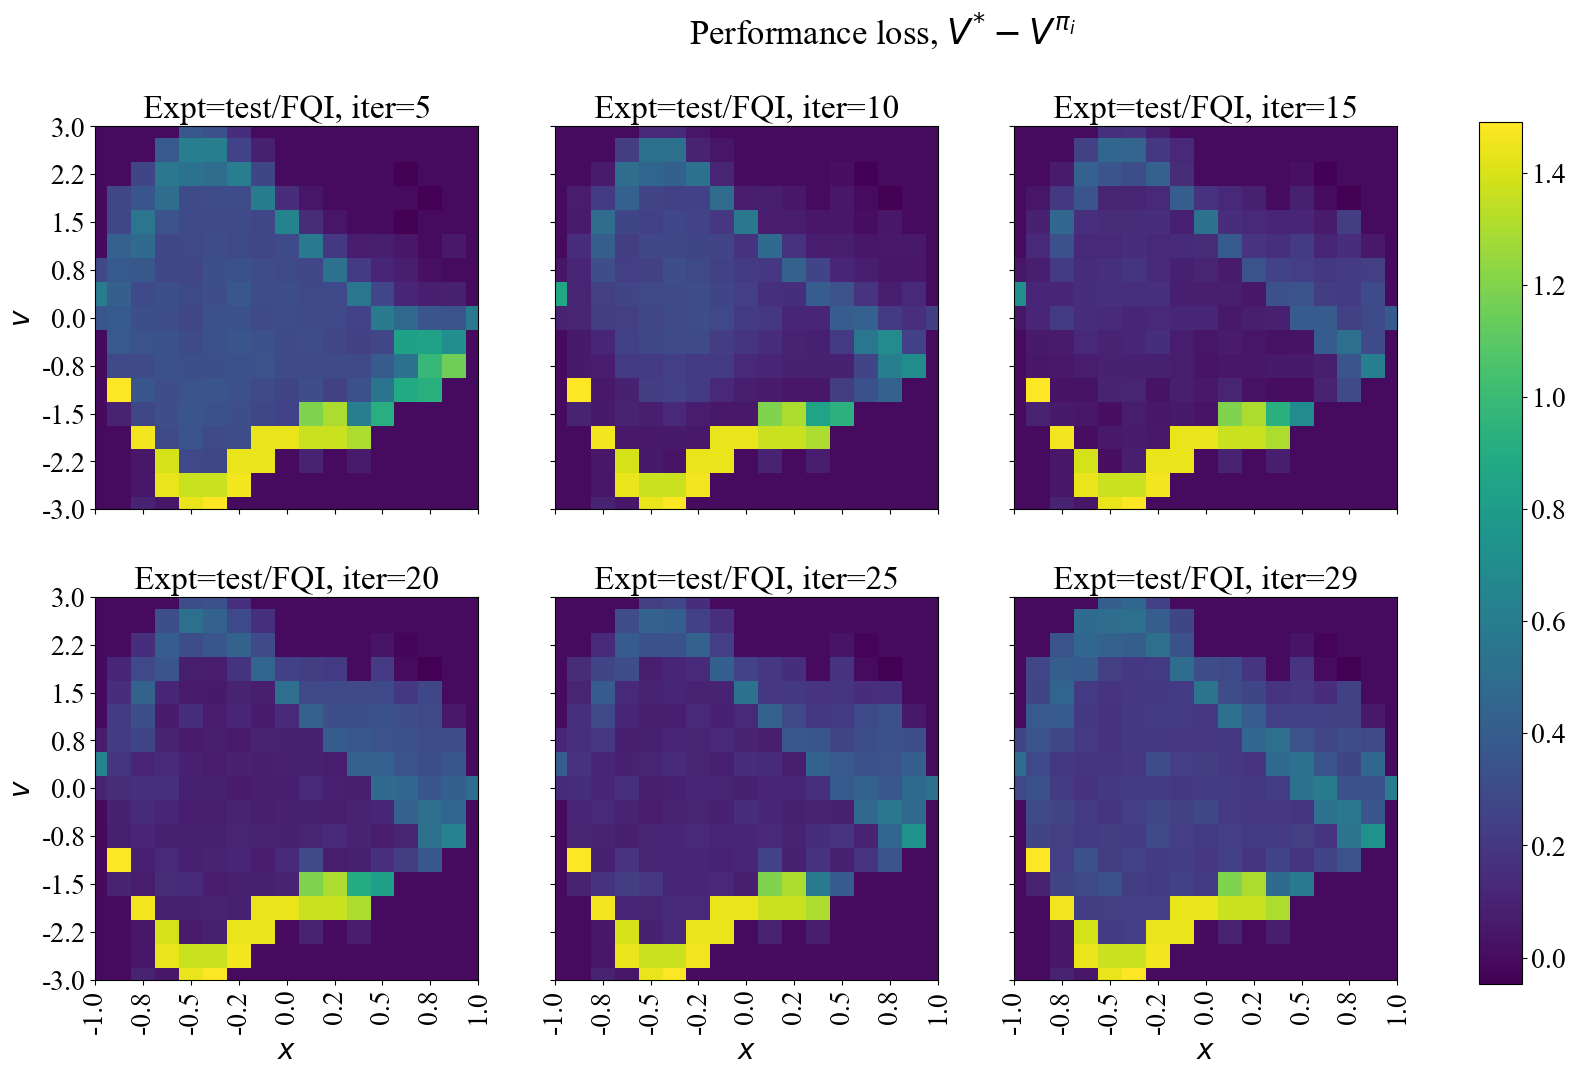

In [158]:
if len(BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS) > 0:
    perf_losses = {}
    for iteration in BELLMAN_ITERATIONS_FOR_PERFORMANCE_LOSS:
        for experiment in experiment_seed_folder_map:
            n_seeds = len(metrics[experiment]["q_grid"])
            v_perf = np.zeros((n_seeds, NX * NV))
            for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
                v_pi_i = metrics[experiment]["q_pi"][seed_run][
                    np.arange(n_bellman_iterations)[:, None],
                    np.arange(NX * NV),
                    np.argmax(metrics[experiment]["q_grid"], axis=-1),
                ][iteration]
                v_perf[idx_seed] = OPT_V.reshape(-1) - v_pi_i
            v_perf = np.mean(v_perf, axis=0)
            v_perf = v_perf.reshape(NX, NV)
            v_perf = v_perf * (metrics[experiment]["scaling"] > 0).astype(float)
            perf_losses[f"Expt={experiment}, iter={iteration}"] = v_perf

    plot_on_grid(
        perf_losses,
        shared_cmap=True,
        title="Performance loss, $V^{*} - V^{\pi_i}$",
        fontsize=20,
        title_fontsize=30,
    ).savefig(
        os.path.join(BASE_PATH, experiment, f"performance_loss_v.pdf"),
        bbox_inches="tight",
    )

## Plot $\Vert Q_{i} - Q^{\pi_i}\Vert_{2, \mu_D}$ on grid

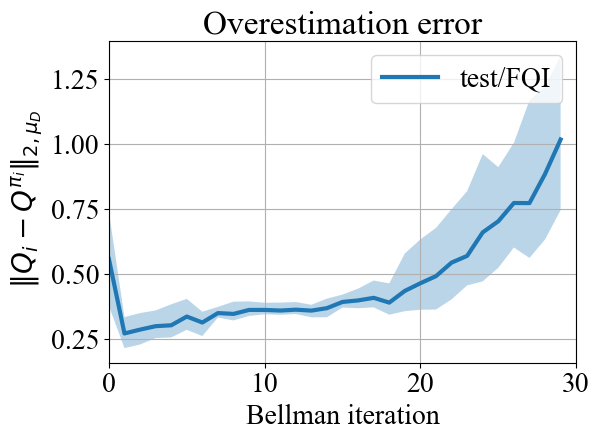

In [144]:
if OVERESTIMATION_ERROR:
    est_err = {}
    for experiment in experiment_seed_folder_map:
        n_seeds = len(metrics[experiment]["q_grid"])
        n_bellman_iterations = list(metrics[experiment]["q_grid"].values())[0].shape[0]
        est_err[experiment] = np.zeros((n_seeds, n_bellman_iterations))
        for idx_seed, seed_run in enumerate(experiment_seed_folder_map[experiment]):
            est_err[experiment][idx_seed] = np.sqrt(
                np.sum(
                    np.square(
                        metrics[experiment]["q_grid"][seed_run]
                        - metrics[experiment]["q_pi"][seed_run]
                    )
                    * metrics[experiment]["scaling"].reshape(-1)[:, np.newaxis],
                    axis=(1, 2),
                )
            )
    plot_value(
        "Bellman iteration",
        " $\Vert Q_{i} - Q^{\pi_i}\Vert_{2, \mu_D}$",
        np.arange(0, n_bellman_iterations).tolist(),
        est_err,
        ticksize=10,
        title="Overestimation error",
        fontsize=20,
        linewidth=3,
        xlim=(0, n_bellman_iterations),
        xticks=[0]
        + [
            idx * 10 ** (int(np.log10(n_bellman_iterations)))
            for idx in range(
                1,
                int(
                    np.ceil(
                        n_bellman_iterations
                        / 10 ** (int(np.log10(n_bellman_iterations)))
                    )
                )
                + 1,
            )
        ],
    ).savefig(
        os.path.join(BASE_PATH, experiments_to_run[0], "overestimation_error_q.pdf"),
        bbox_inches="tight",
    )